In [1]:
import model 
import data 
import matplotlib.pyplot as plt
from importlib import reload
reload(data)
reload(model)

<module 'model' from '/tf/notebooks/PixelWise_Cell_Classification/V2/unet/model.py'>

In [2]:
# for Gunpowder
ZARR_FOLDER_TRAIN = '../../../../data/cells/raw/zarr/train/'
ZARR_FOLDER_TEST = '../../../../data/cells/raw/zarr/test/'
gp_batch_size= 12
gp_voxel_shape = [1,1,1]
gp_input_shape= [256, 256,4]
gp_output_shape = [ 256, 256,4]

# For unet
OUTPUT_PATH = '../../../../data/cells/models/'

unet_input_size = (256,256,4)
unet_output_size = 3

In [43]:
from datetime import date

today = date.today()

d1 = today.strftime("%d_%m_%Y_")
base_name = d1+'unet_without_bg_cells'
model_name = base_name+'.hdf5'
model_name

'13_09_2020_unet_without_bg_cells.hdf5'

### Check data 

In [4]:
gen_train_fast = data.generate_fast_training_batch_without_background(ZARR_FOLDER_TRAIN, batch_size=gp_batch_size
                                              ,voxel_shape = gp_voxel_shape,
                                              input_shape= gp_input_shape,output_shape = gp_output_shape )
gen_test_fast = data.generate_fast_training_batch_without_background(ZARR_FOLDER_TEST, batch_size=gp_batch_size
                                              ,voxel_shape = gp_voxel_shape,
                                              input_shape= gp_input_shape,output_shape = gp_output_shape )

In [5]:
im,mask = next(gen_train_fast)
print(im.shape)

(12, 256, 256, 4)


In [6]:
test_im = im[0]
test_mask = mask[0]

print('Img size: {} {} < {} | Mask size: {} {} <{}'.format(test_im.shape,test_im.dtype,test_im.max()
                                                                   ,test_mask.shape,test_mask.dtype,test_mask.max()))

Img size: (256, 256, 4) float32 < 1.0 | Mask size: (256, 256, 3) float32 <1.0


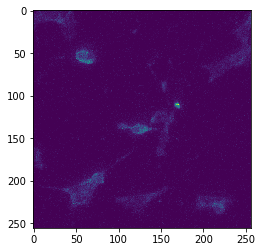

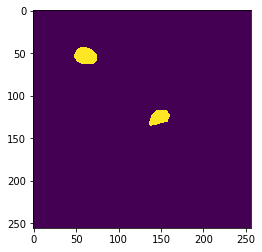

In [7]:
plt.imshow(test_im[:,:,2])
plt.show()
plt.imshow(test_mask[:,:,0])
plt.show()

### Model

In [8]:
unet_model = model.unet(input_size = unet_input_size ,output_size = unet_output_size)

In [9]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Train

In [40]:
GRAPHS_FOLDER = '../../../../data/cells/graphs/'
GRAPH_NAME = os.path.join(GRAPHS_FOLDER,base_name+'.png')
plt.savefig('output/Epoch-{}.png'.format(epoch))
from tensorflow import keras
import IPython.display as display
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.history = {}
        self.fig = plt.figure()
        
        self.logs = []
#         plt.show()

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        for l in logs:
            if l not in self.history:
                self.history[l]=[]
            self.history[l].append(logs.get(l))
        self.i += 1
        
        display.clear_output(wait=True)
        for l in logs:
            plt.plot(self.x, self.history[l], label=l)
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import os
import PersonalizedCallbacks

model_file = os.path.join(OUTPUT_PATH,model_name)
# mean_io_u
model_checkpoint = ModelCheckpoint(model_file, monitor='val_loss',verbose=0, save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

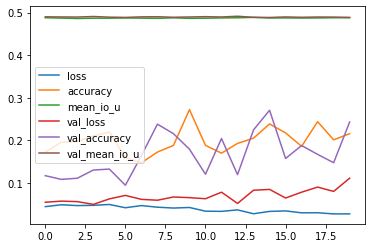

8/8 [==============================] - 9s 1s/step - loss: 0.0272 - accuracy: 0.2155 - mean_io_u: 0.4879 - val_loss: 0.1110 - val_accuracy: 0.2430 - val_mean_io_u: 0.4887


In [42]:

history = unet_model.fit_generator(gen_train_fast,validation_data =gen_test_fast,validation_steps=5,steps_per_epoch=40,epochs=20,callbacks=[plot_losses],verbose=1)


### Test

In [ ]:
im,mask = next(gen_train_fast)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(im[0][:,:,2])
# print(im[0])

In [ ]:
results = unet_model.predict(im)

In [ ]:
plt.imshow(results[3][:,:,1])

In [ ]:
import json
history2_file = os.path.join(OUTPUT_PATH,d1+'history_unet_without_background_cells.json')
history_v2_dict = history.history
json.dump(str(history_v2_dict), open(history2_file, 'w'))

In [ ]:
str(history_v2_dict)

In [ ]:
from tensorflow.python import keras
print(keras.__version__)